In [1]:
#@title MONTAR EL DRIVE { display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
#print(os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title Importación de libreríías { display-mode: "form" }
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import os
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Preparación del dataset:

In [3]:
#Ruta del directorio del dataset
DatasetDir = os.path.join(os.getcwd(), "drive", "My Drive", "Proyecto_IA", "HAM10000_Data")
df = pd.read_csv(os.path.join(DatasetDir,'HAM10000_metadata.csv'))

*   Bowen's disease => akiec
*   Basal cell carcinoma =>  bcc 
*   Benign keratosis => bkl
*   Dermatofibroma => df
*   Melanoma => mel
*   Melanocytic nevi => nv
*   Vascular lesions => vasc

### Cargado de datos

In [4]:
def get_paths_labels(DatasetDir, class_balancing = False):
  train_metadata ='HAM10000_metadata.csv'
  #test_metadata = "ISIC2018_Task3_Test_NatureMedicine_AI_Interaction_Benefit.csv"

  train = os.path.join(DatasetDir, train_metadata) 

  df = pd.read_csv(train)

  if (class_balancing):
    g = df.groupby('dx')
    df =g.apply(lambda x: x.sample(int(g.size().mean()), replace=True)).reset_index(drop=True)

  lb_style = LabelBinarizer()
  lb_results = lb_style.fit_transform(df.dx)
  target = pd.DataFrame(  lb_results, columns=lb_style.classes_)
  target["image_id"] = df["image_id"]

  images_path = os.path.join(DatasetDir,"HAM10000_images")

  paths =  [images_path + "/" + id for id in target["image_id"]]


  return (pd.Series(paths), target, lb_style)

In [18]:
class DataGeneratorConSeg(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=100, dim=(128,128), n_channels=3,
                 n_classes=7, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def read_image(self,path, tam=(128,128)):
      im = None
      seg_path = os.path.join(DatasetDir,"HAM10000_segmentations",path.split("/")[-1]+"_segmentation.png")
      if (os.path.exists(path+".jpg")and os.path.exists(seg_path) ):
        segmentation = cv2.imread(seg_path)*1./255
        imagen = cv2.imread(path+".jpg")*1./255


        fila_min = np.nonzero(segmentation[:,:,0])[0].min()
        fila_max = np.nonzero(segmentation[:,:,0])[0].max()
        col_min = np.nonzero(segmentation[:,:,0])[1].min()
        col_max = np.nonzero(segmentation[:,:,0])[1].max()


        im = cv2.resize(np.multiply(imagen[fila_min:fila_max,col_min:col_max,:], segmentation[fila_min:fila_max,col_min:col_max,:]),tam)
      else:
        print("Seg exists: ",os.path.exists(seg_path) )
        print("Im exists: ",os.path.exists(path+".jpg") )
        raise Exception("Error cargando: ", path.split("/")[-1]+".jpg" )
      return im
      
    def get_target(self,path):
      return self.labels[self.labels.image_id==path.split("/")[-1]].iloc[0,:-1]

    def __getitem__(self, index):
        
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs.iloc[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size,self.n_classes))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.read_image(ID, self.dim)
            # Store class
            y[i,] = self.get_target(ID)

        return X, y

    def one_data(self, ID):
      return  self.read_image(ID, self.dim), self.get_target(ID)


class DataGeneratorVisualizarDataset(DataGeneratorConSeg):
  def read_image(self, path, tam=(128,128)):
    imOriginal = None
    if (os.path.exists(path+".jpg")):
      segmentation =cv2.imread(os.path.join(DatasetDir,"HAM10000_segmentations",path.split("/")[-1]+"_segmentation.png"))*1/255
      imOriginal =cv2.imread(path+".jpg")*1/255
      imSegmenZoomeada = np.multiply(imOriginal, segmentation)



      fila_min = np.nonzero(segmentation[:,:,0])[0].min()
      fila_max = np.nonzero(segmentation[:,:,0])[0].max()
      col_min = np.nonzero(segmentation[:,:,0])[1].min()
      col_max = np.nonzero(segmentation[:,:,0])[1].max()

      
      imSegmenZoomeada = cv2.resize(np.multiply(imOriginal[fila_min:fila_max,col_min:col_max,:], segmentation[fila_min:fila_max,col_min:col_max,:]),tam)
      imOriginal = cv2.resize(imOriginal,tam)
      segmentation = cv2.resize(segmentation,tam)
    else:
      raise Exception("Error cargando: ", path.split("/")[-1]+".jpg" )
    return imOriginal, segmentation, imSegmenZoomeada

  def one_data(self, ID):
    imOriginal, segmentacion, imSegmenZoomeada = self.read_image(ID, self.dim)
    return imOriginal, segmentacion, imSegmenZoomeada , self.get_target(ID)



#
log_folder = "/"
for folder in DatasetDir.split("/")[:-1]:
  log_folder = os.path.join(log_folder, folder)

checkpoint_path_unet =  os.path.join(log_folder,"checkpoints_model_seg", "cp.ckpt")
model_unet = tf.keras.models.load_model(checkpoint_path_unet)

class DataGeneratorMatrizConf(DataGeneratorConSeg):
  def read_image(self,path,dim = (128, 128)):
    im = None

    if (os.path.exists(path+".jpg")):

      
      imagen = cv2.resize(cv2.imread(path+".jpg"),dim)*1/255
      #print(imagen.shape)
      salida_red = model_unet.predict(np.expand_dims(cv2.resize(imagen,dim),0))[0,:,:,0]
      segmentation  = cv2.threshold(salida_red,np.mean(salida_red),1,cv2.THRESH_BINARY)[1]
      segmentation = cv2.cvtColor(segmentation ,cv2.COLOR_GRAY2RGB) 

      filas, cols = np.nonzero(segmentation[:,:,0])

      fila_min, fila_max = filas.min(), filas.max()
      col_min, col_max = cols.min(), cols.max()

      imagen = imagen[fila_min:fila_max+1,col_min:col_max+1,:]
      
      segmentation =segmentation[fila_min:fila_max+1,col_min:col_max+1,:]
      
      im =  cv2.resize(np.multiply(imagen,segmentation),dim)
      #print(im.shape, (*dim, 3))
      assert im.shape == (*dim, 3)
    else:
      print("Im exists: ",os.path.exists(path+".jpg") )
      raise Exception("Error cargando: ", path.split("/")[-1]+".jpg" )
    return im

### ¿Cómo se ve nuestro dataset?

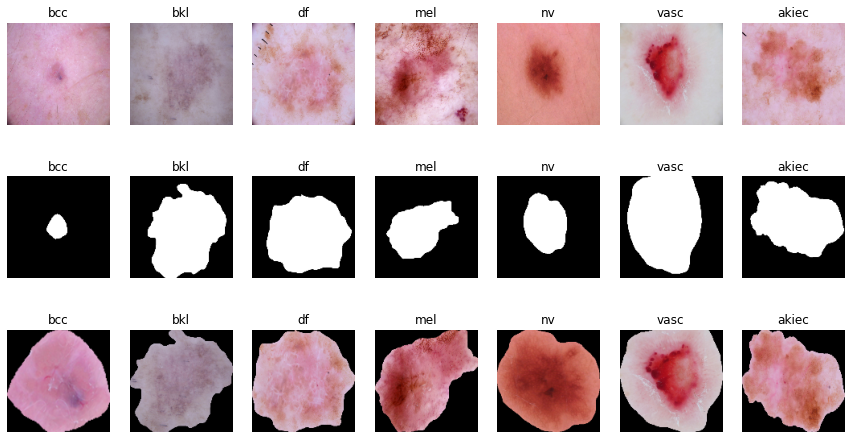

In [ ]:
VER = True
def plot_subplot(ax, img,  label):
  ax.imshow(img)#, interpolation="nearest")
  ax.set_title(label)
  ax.axis("off")

dataAug = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0)
  ])
if (VER):
  num_iagenes = 10
  X,Y,lb_style = get_paths_labels(DatasetDir, class_balancing=True)
  datos_completos = DataGeneratorVisualizarDataset(X,Y,batch_size=5,dim=(128,128))

  perm = np.random.permutation(range(X.shape[0]))
  random_imgs   = X.values[perm]
  random_labels = Y.values[perm,:-1]
  #print(random_labels[0])
  sum = 0
  indices = np.empty((7,), dtype=np.uint8)
  for i in range(7):
    idx = np.where(np.argmax(random_labels, axis=1)==i)[0][0]
    indices[i] = idx

  clases = lb_style.classes_
  fig, axs = plt.subplots(3, 7, figsize=(15,8))
  for i,idx in enumerate(indices):
    imOriginal, segmentacion, imSegmenZoomeada, label = datos_completos.one_data(random_imgs[idx])
    label = lb_style.classes_[np.where(label.values)[0]][0]
    img = imOriginal[:,:,::-1]
    ax = axs[0,i-1]
    plot_subplot(ax,img, label)

    img = segmentacion[:,:,::-1]
    ax = axs[1,i-1]
    plot_subplot(ax,img,label)

    img = imSegmenZoomeada[:,:,::-1]
    ax = axs[2,i-1]
    plot_subplot(ax,img,label)
#fig.savefig(os.path.join(os.getcwd(), "drive", "My Drive", "Proyecto_IA","imágenes", "dataset_vista.svg"))

df


(-0.5, 127.5, 127.5, -0.5)

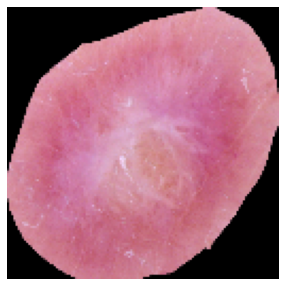

In [ ]:
idx = np.random.randint(X.shape[0])
imOriginal, segmentacion, imSegmenZoomeada, label = datos_completos.one_data(random_imgs[idx])
label = lb_style.classes_[np.where(label.values)[0]][0]
print(label)
img = imSegmenZoomeada[:,:,::-1]
fig = plt.figure(figsize=(5,5))
plt.imshow(img)
ax = plt.gca()
ax.axis("off")
#fig.savefig(os.path.join(os.getcwd(), "drive", "My Drive", "Proyecto_IA","imágenes", "lesion_segmentada.svg"))

df


(-0.5, 127.5, 127.5, -0.5)

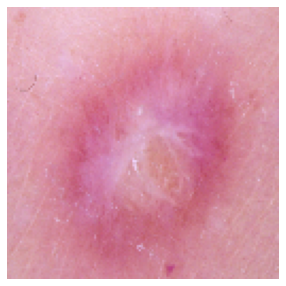

In [ ]:
print(label)
img = imOriginal[:,:,::-1]
fig = plt.figure(figsize=(5,5))
plt.imshow(img)
ax = plt.gca()
ax.axis("off")
#fig.savefig(os.path.join(os.getcwd(), "drive", "My Drive", "Proyecto_IA","imágenes", "lesion_original.svg"))

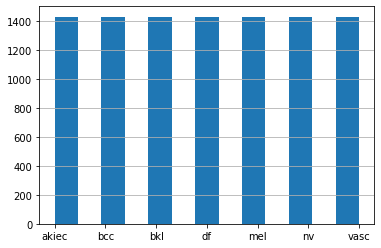

In [ ]:
g = df.groupby('dx')
fig = g.apply(lambda x: x.sample(int(g.size().mean()), replace=True)).reset_index(drop=True).dx.hist(grid = False, bins=13, alpha=1).get_figure()
ax = fig.gca()
ax.grid(axis='y')
#fig.savefig(os.path.join(os.getcwd(), "drive", "My Drive", "Proyecto_IA","imágenes", "hitograma_clases_post_procesamiento.svg"))

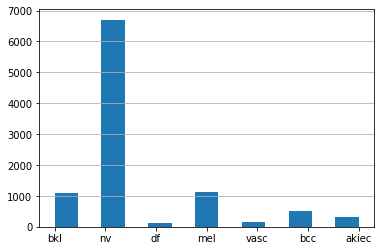

In [ ]:
fig = df.dx.hist(grid = False, bins=13, alpha=1).get_figure()
ax = fig.gca()
ax.grid(axis='y')
#fig.savefig(os.path.join(os.getcwd(), "drive", "My Drive", "Proyecto_IA","imágenes", "hitograma_clases_pre_procesamiento.svg"))

In [ ]:
#
log_folder = "/"
for folder in DatasetDir.split("/")[:-1]:
  log_folder = os.path.join(log_folder, folder)

checkpoint_path =  os.path.join(log_folder,"checkpoints_model_clas_seg", "cp.ckpt")
model = tf.keras.models.load_model(checkpoint_path)

In [ ]:
BATCH_SIZE = 32
X,Y,lb_style = get_paths_labels(DatasetDir, class_balancing=True)
testing_generator = DataGeneratorMatrizConf(X,Y,batch_size=BATCH_SIZE,dim=(128,128))
  


In [ ]:
cant = testing_generator.list_IDs.shape[0]
Y_REAL = np.empty(((cant//BATCH_SIZE)*BATCH_SIZE,7))
Y_PRED = np.empty(((cant//BATCH_SIZE)*BATCH_SIZE,7))
for idx in range(cant//BATCH_SIZE):
  #print(idx)
  x,y = testing_generator.__getitem__(idx)
  Y_REAL[(idx*BATCH_SIZE):((idx+1)*BATCH_SIZE),:] = y
  Y_PRED[(idx*BATCH_SIZE):((idx+1)*BATCH_SIZE),:] = model.predict(x, batch_size=32)

In [ ]:
Y_REAL_CAT = np.argmax(Y_REAL, axis=1)
Y_PRED_CAT = np.argmax(Y_PRED, axis=1)

In [ ]:
conf_mat = confusion_matrix(Y_REAL_CAT, Y_PRED_CAT)

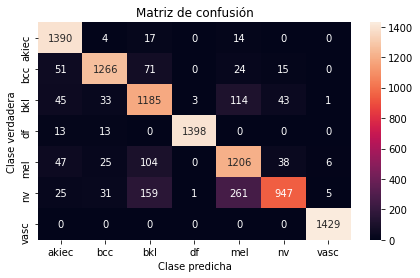

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1425
           1       0.92      0.89      0.90      1427
           2       0.77      0.83      0.80      1424
           3       1.00      0.98      0.99      1424
           4       0.74      0.85      0.79      1426
           5       0.91      0.66      0.77      1429
           6       0.99      1.00      1.00      1429

    accuracy                           0.88      9984
   macro avg       0.89      0.88      0.88      9984
weighted avg       0.89      0.88      0.88      9984



In [ ]:
ytest, ypredict = Y_REAL_CAT, Y_PRED_CAT

conf_matrix = confusion_matrix(ytest, ypredict)
fig = plt.figure(figsize=(7, 4))
sns.heatmap(conf_matrix, xticklabels=lb_style.classes_, yticklabels=lb_style.classes_, annot=True, fmt="d");
plt.title("Matriz de confusión")
plt.ylabel('Clase verdadera')
plt.xlabel('Clase predicha')
plt.show()
print (classification_report(ytest, ypredict))

In [ ]:
#fig.savefig(os.path.join(os.getcwd(), "drive", "My Drive", "Proyecto_IA","imágenes", "MatrizConf.svg"))

In [5]:
#@title  MOSTRAR DATOS Segmentación antigua { display-mode: "form" }

class DataGeneratorSegmentacionAntigua(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=100, dim=(128,128), n_channels=3,
                 n_classes=4, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def read_image(self,path, tam=128):
      return cv2.resize(cv2.imread(path+".jpg"), (tam,tam))*1./255
      
    def get_target(self,labels, tam=128):
      return cv2.resize(cv2.imread(os.path.join(DatasetDir,"HAM10000_segmentations",labels+"_segmentation.png")), (tam,tam))[:,:,0]*1./255
      #return self.labels[self.labels.image_id==path.split("/")[-1]].iloc[0,:-1]

    def __getitem__(self, index):
        
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs.iloc[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim))
#        y = np.empty((self.batch_size,self.n_classes))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.read_image(ID)
            # Store class
            y[i,] = self.get_target(ID.split("/")[-1])

        return X, y

    def one_data(self, ID):
      return  self.read_image(ID), self.get_target(ID)


In [8]:
BATCH_SIZE = 32
def get_paths_labels(DatasetDir):
  train_metadata ='HAM10000_metadata.csv'
  test_metadata = "ISIC2018_Task3_Test_NatureMedicine_AI_Interaction_Benefit.csv"

  train = os.path.join(DatasetDir, train_metadata) 

  df = pd.read_csv(train)

  lb_style = LabelBinarizer()
  lb_results = lb_style.fit_transform(df.dx_type)
  target = pd.DataFrame(  lb_results, columns=lb_style.classes_)
  target["image_id"] = df["image_id"]

  images_path = os.path.join(DatasetDir,"HAM10000_images")
  images_pathS = os.path.join(DatasetDir,"HAM10000_segmentations")

  paths =  [images_path + "/" + id for id in target["image_id"]]
  target = [images_pathS + "/" + id for id in target["image_id"]]

  return (pd.Series(paths), pd.Series(target))

X,Y = get_paths_labels(DatasetDir)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#training_generator = DataGenerator(X_train, Y_train, batch_size=BATCH_SIZE)
#testing_generator = DataGenerator(X_test, Y_test, batch_size=BATCH_SIZE)

In [44]:
Y_train = [i for i in Y_train[0:10]]

(-0.5, 127.5, 127.5, -0.5)

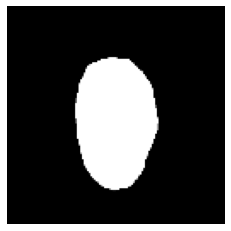

In [73]:

i = 6
#grayscale = 255 - cv2.imread(X[i]+".jpg")[:,:,1]
img = cv2.imread(X[i]+".jpg")
groundtruth = cv2.imread(Y[i]+"_segmentation.png")
fig = plt.figure(figsize=(7, 4))
plt.imshow(cv2.resize(groundtruth,(128,128)))
plt.axis('off')
#fig.savefig(os.path.join(os.getcwd(), "drive", "My Drive", "Proyecto_IA","imágenes", "Ground_truth_segmentacion.svg"))

Threshold value is 79


(-0.5, 127.5, 127.5, -0.5)

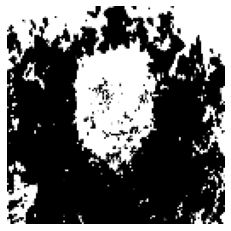

In [74]:
#OTSU
import scipy
from skimage.filters import threshold_otsu
grayscale = 255 - cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

median_filtered = scipy.ndimage.median_filter(grayscale, size=3)
threshold =threshold_otsu(median_filtered)
print('Threshold value is {}'.format(threshold))
predicted = np.uint8(median_filtered > threshold) * 255
fig = plt.figure(figsize=(7, 4))
plt.imshow(cv2.resize(predicted,(128,128)), cmap='gray')
plt.axis('off')
#fig.savefig(os.path.join(os.getcwd(), "drive", "My Drive", "Proyecto_IA","imágenes", "OTSU_segmentacion.svg"))

(-0.5, 127.5, 127.5, -0.5)

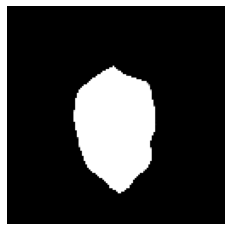

In [75]:
#Unet

imagen = cv2.resize(img,(128,128))
fig = plt.figure(figsize=(7, 4))


plt.imshow(model_unet.predict(np.expand_dims(imagen,0))[0,:,:,0], cmap='gray')
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

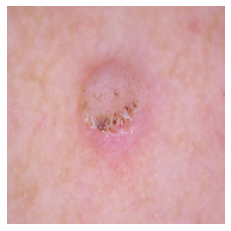

In [76]:
 plt.imshow(imagen[:,:,::-1])
 plt.axis('off')

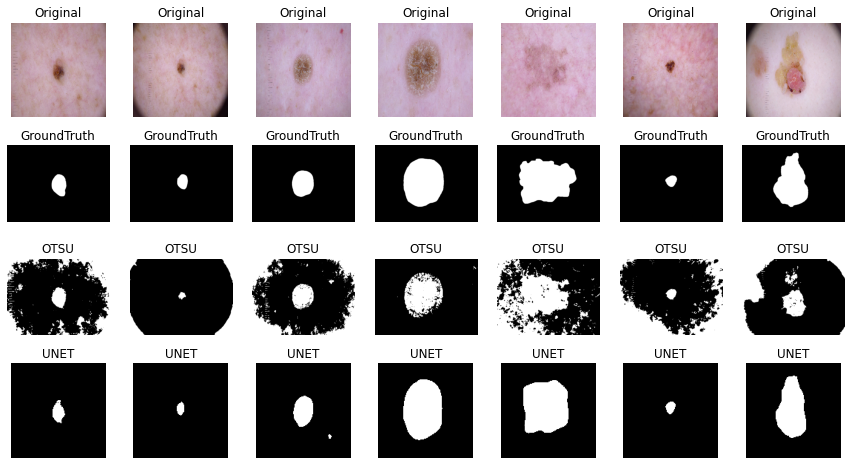

In [94]:
fig, axs = plt.subplots(4, 7, figsize=(15,8))
def plot_subplot(ax, img,  label, gray=False):
  if (gray):

    ax.imshow(img, cmap='gray')#, interpolation="nearest")
  else:
    ax.imshow(img)
  ax.set_title(label)
  ax.axis("off")
for i,idx in enumerate(np.arange(10,17)):
  img = cv2.imread(X[idx]+".jpg")
  imagen = cv2.resize(img,(128,128))
  groundtruth = cv2.imread(Y[idx]+"_segmentation.png")


  grayscale = 255 - cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  median_filtered = scipy.ndimage.median_filter(grayscale, size=3)
  threshold =threshold_otsu(median_filtered)
  predicted = np.uint8(median_filtered > threshold) * 255


  im_unet = model_unet.predict(np.expand_dims(imagen,0))[0,:,:,0]
 
  img = imagen[:,:,::-1]
  ax = axs[0,i-1]
  plot_subplot(ax,img, "Original")

  img = groundtruth[:,:,0]
  ax = axs[1,i-1]
  plot_subplot(ax,img, "GroundTruth", True)

  img = predicted
  ax = axs[2,i-1]
  plot_subplot(ax,img,"OTSU", True)

  img = im_unet
  ax = axs[3,i-1]
  plot_subplot(ax,img,"UNET", True)

In [95]:
fig.savefig(os.path.join(os.getcwd(), "drive", "My Drive", "Proyecto_IA","imágenes", "Comparación segmentaciones.svg"))